# Simple Advection example in 2d

In two spatial dimensions, the advection equation reads

$$ \frac{\partial u}{\partial t} + c_0 \frac{\partial u}{\partial x_0} + c_1
\frac{\partial u}{\partial x_1} = 0. $$

In contrast to the 1d case, there is now a first derivative both in $x_0$ and
$x_1$ direction. For each dimension, there is a respective advection speed $c_0$
and $c_1$.

If we assume periodic boundary conditions and lets domain span $L$ in both
dimensions, i.e., $\Omega = (0, L)^2$, the analytical solution is given by

$$ u(x_0, x_1, t) = u_0((x_0 - c_0 t) \mod L, (x_1 - c_1 t) \mod L). $$

using some loose notation of the modulo operator.

Similar to the 1d case, the initial condition $u_0(x_0, x_1)$ is moved. Its
shape is preserved.

This tutorial assumes that you have read the [1d advection tutorial].

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
import exponax as ex

In [3]:
DOMAIN_EXTENT = 1.0
NUM_POINTS = 20

In [4]:
grid = ex.make_grid(
    2,
    DOMAIN_EXTENT,
    NUM_POINTS,
)

grid.shape

2024-03-07 09:42:11.733736: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(2, 20, 20)

Notice, how we again exclude the right boundary point from the grid. In 2d, this
generalizes to the $x_1$ direction not having the top row of points.

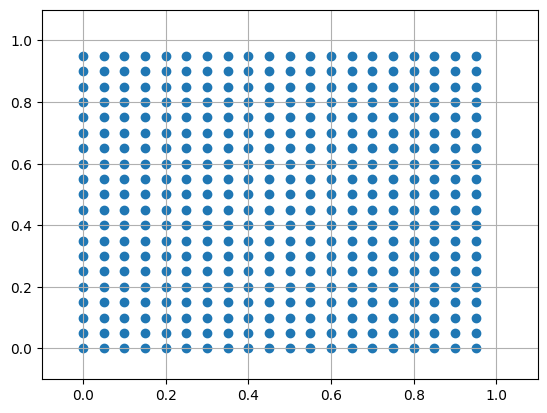

In [5]:
plt.scatter(grid[0].flatten(), grid[1].flatten())
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid()

Let's discretize a function on that grid that is composed of the first sine mode
in $x_0$ direction and the second cosine mode in $x_1$ direction.

Note that we slice the grid to maintain a singleton channel dimension. This is
important.

In [ ]:
def ic_fun(x):
    return jnp.sin(1 * 2 * jnp.pi * x[0:1] / DOMAIN_EXTENT) * jnp.cos(
        2 * 2 * jnp.pi * x[1:2] / DOMAIN_EXTENT
    )


ic = ic_fun(grid)
ic.shape

(1, 20, 20)

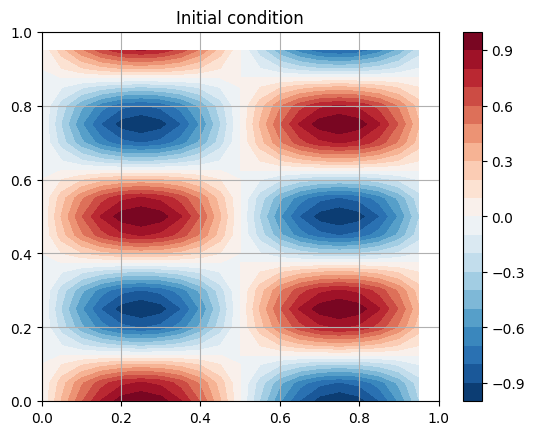

In [7]:
plt.contourf(
    grid[0],
    grid[1],
    ic[0],  # Now we have to remove the singleton channel axis
    cmap="RdBu_r",
    levels=jnp.linspace(-1, 1, 21),
)
plt.xlim(0.0, DOMAIN_EXTENT)
plt.ylim(0.0, DOMAIN_EXTENT)
plt.colorbar()
plt.grid()
plt.title("Initial condition");

We can also wrap around the state

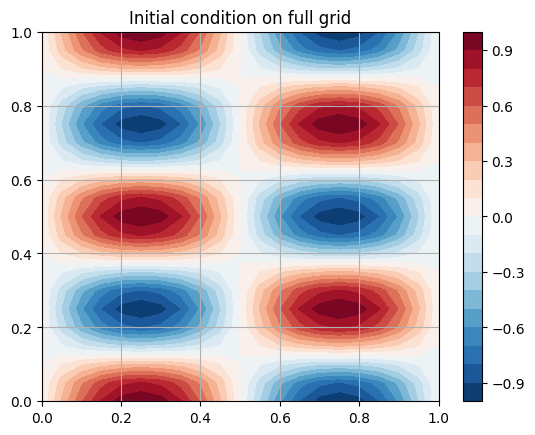

In [8]:
full_grid = ex.make_grid(
    2,
    DOMAIN_EXTENT,
    NUM_POINTS,
    full=True,
)
full_ic = ex.wrap_bc(ic)
plt.contourf(
    full_grid[0],
    full_grid[1],
    full_ic[0],
    cmap="RdBu_r",
    levels=jnp.linspace(-1, 1, 21),
)
plt.xlim(0.0, DOMAIN_EXTENT)
plt.ylim(0.0, DOMAIN_EXTENT)
plt.colorbar()
plt.grid()
plt.title("Initial condition on full grid");

Let's begin by assuming that the advection speed in both dimensions is the same
$c_0 = c_1 = 1$.

In [9]:
VELOCITY = 1.0
DT = 0.2

advection_stepper_2d = ex.stepper.Advection(
    2,
    DOMAIN_EXTENT,
    NUM_POINTS,
    DT,
    velocity=VELOCITY,
)

advection_stepper_2d

Advection(
  num_spatial_dims=2,
  domain_extent=1.0,
  num_points=20,
  num_channels=1,
  dt=0.2,
  dx=0.05,
  _integrator=ETDRK0(dt=0.2, _exp_term=c64[1,20,11]),
  velocity=f32[2]
)

In [10]:
u_1 = advection_stepper_2d(ic)

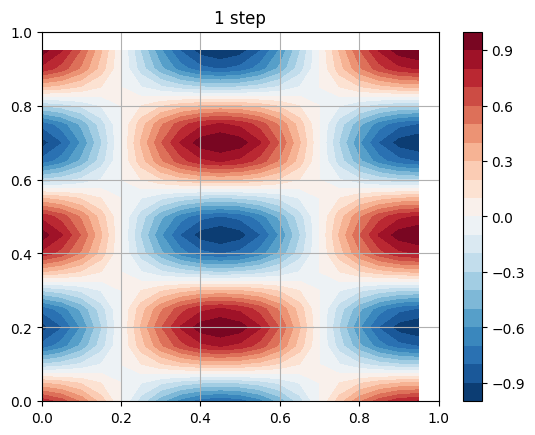

In [11]:
plt.contourf(grid[0], grid[1], u_1[0], cmap="RdBu_r", levels=jnp.linspace(-1, 1, 21))
plt.xlim(0.0, DOMAIN_EXTENT)
plt.ylim(0.0, DOMAIN_EXTENT)
plt.colorbar()
plt.grid()
plt.title("1 step");

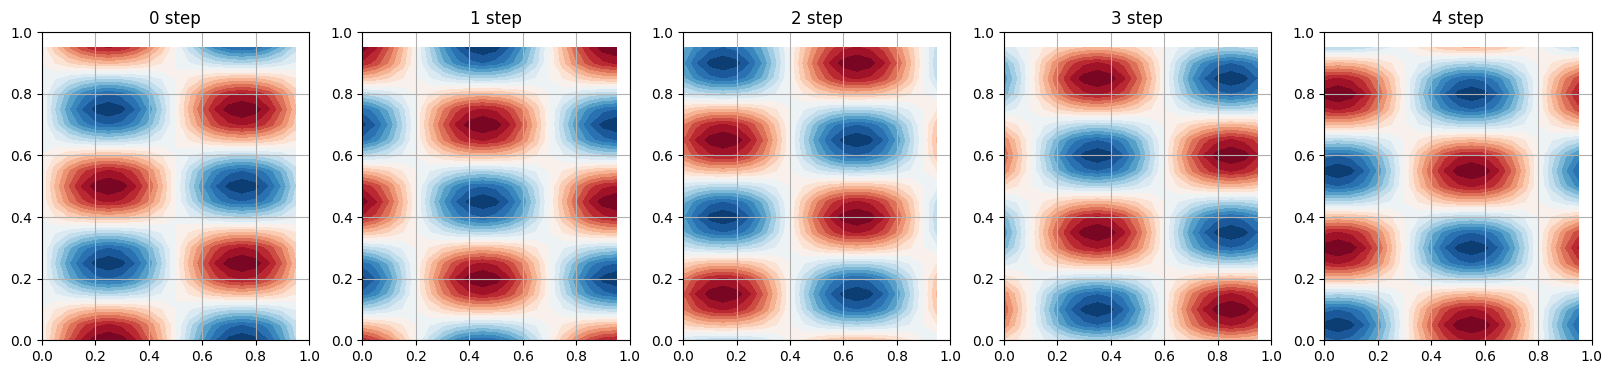

In [12]:
u_2 = advection_stepper_2d(u_1)
u_3 = advection_stepper_2d(u_2)
u_4 = advection_stepper_2d(u_3)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, u in enumerate([ic, u_1, u_2, u_3, u_4]):
    ax = axs[i]
    ax.contourf(grid[0], grid[1], u[0], cmap="RdBu_r", levels=jnp.linspace(-1, 1, 21))
    ax.set_xlim(0.0, DOMAIN_EXTENT)
    ax.set_ylim(0.0, DOMAIN_EXTENT)
    ax.grid()
    ax.set_title(f"{i} step")

In [13]:
SMALLER_DT = 0.01
slower_advection_stepper = ex.stepper.Advection(
    2,
    DOMAIN_EXTENT,
    NUM_POINTS,
    SMALLER_DT,
    velocity=VELOCITY,
)
trajectory = ex.rollout(
    slower_advection_stepper,
    40,
    include_init=True,
)(ic)
trajectory.shape

(41, 1, 20, 20)

In [14]:
fig, ax = plt.subplots(1, 1)
im = ax.contourf(
    grid[0], grid[1], trajectory[0][0], cmap="RdBu_r", levels=jnp.linspace(-1, 1, 21)
)
ax.set_xlim(0.0, DOMAIN_EXTENT)
ax.set_ylim(0.0, DOMAIN_EXTENT)
ax.grid()
ax.set_title("0 steps")


def update(frame):
    for c in ax.collections:
        c.remove()
    im = ax.contourf(
        grid[0],
        grid[1],
        trajectory[frame][0],
        cmap="RdBu_r",
        levels=jnp.linspace(-1, 1, 21),
    )
    ax.set_title(f"{frame} steps")
    return (im,)


plt.close(fig)

ani = FuncAnimation(
    fig,
    update,
    frames=trajectory.shape[0],
    blit=True,
    interval=100,
)

HTML(ani.to_jshtml())

Let's do an advection with different advection speeds in each axis

In [15]:
SMALLER_DT = 0.01
DIFFERENT_VELOCITY = jnp.array([0.5, 2.0])
slower_advection_stepper = ex.stepper.Advection(
    2,
    DOMAIN_EXTENT,
    NUM_POINTS,
    SMALLER_DT,
    velocity=DIFFERENT_VELOCITY,
)
trajectory = ex.rollout(
    slower_advection_stepper,
    40,
    include_init=True,
)(ic)
trajectory.shape

(41, 1, 20, 20)

In [16]:
fig, ax = plt.subplots(1, 1)
im = ax.contourf(
    grid[0], grid[1], trajectory[0][0], cmap="RdBu_r", levels=jnp.linspace(-1, 1, 21)
)
ax.set_xlim(0.0, DOMAIN_EXTENT)
ax.set_ylim(0.0, DOMAIN_EXTENT)
ax.grid()
ax.set_title("0 steps")


def update(frame):
    for c in ax.collections:
        c.remove()
    im = ax.contourf(
        grid[0],
        grid[1],
        trajectory[frame][0],
        cmap="RdBu_r",
        levels=jnp.linspace(-1, 1, 21),
    )
    ax.set_title(f"{frame} steps")
    return (im,)


plt.close(fig)

ani = FuncAnimation(
    fig,
    update,
    frames=trajectory.shape[0],
    blit=True,
    interval=100,
)

HTML(ani.to_jshtml())